In [1]:
# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
import holodeck.gravwaves
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR, SPLC

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode

log = holo.log
log.setLevel(logging.INFO)

In [50]:
def plot_bin_pop(pop):
    mt, mr = utils.mtmr_from_m1m2(pop.mass)
    redz = cosmo.a_to_z(pop.scafa)
    data = [mt/MSOL, mr, pop.sepa/PC, 1+redz]
    data = [np.log10(dd) for dd in data]
    reflect = [None, [None, 0], None, [0, None]]
    labels = [r'M/M_\odot', 'q', r'a/\mathrm{{pc}}', '1+z']
    labels = [r'${{\log_{{10}}}} \left({}\right)$'.format(ll) for ll in labels]

    if pop.eccen is not None:
        data.append(pop.eccen)
        reflect.append([0.0, 1.0])
        labels.append('e')

    kde = kale.KDE(data, reflect=reflect)
    corner = kale.Corner(kde, labels=labels, figsize=[8, 8])
    corner.plot_data(kde)
    return corner

def compare_bin_pops(pops, labels=None, var='mass', colors=None, lws=None, 
                     density=True, hist=False, confidence=False):
    assert isinstance(pops, list), '`pops` must be a list of binary populations'
    assert var in ['mass','mrat','sepa','redz'], "`var` must be 'mass','mrat','sepa', or 'redz'."
    if (labels is not None):
        if (len(labels) != len(pops)) and (not isinstance(labels,str)):
            print("Warning: `labels` must be a str or a list of length len(pops). Setting to None.")
            labels = None
   
    fig, ax = plt.subplots(figsize=[10, 5])
    ax.set(ylabel='Probability Density')
    ax.grid(alpha=0.01)
    
    if (colors is not None) and (lws is None):
        lws = [1.0]*len(pops)

    if (var == 'mass') or (var == 'mrat'):
        for i,pop in enumerate(pops):
            mt, mr = utils.mtmr_from_m1m2(pop.mass)
            data = np.log10(mt/MSOL) if var=='mass' else mr
            #print(data.min(),data.max())
            xlab = r'$\log_{10}(M_{tot})$' if var=='mass' else r'$q$'
            ax.set(xlabel=xlab)
            if colors is None:
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, label=labels[i])
            else: 
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, 
                            label=labels[i], color=colors[i], lw=lws[i])

    elif var == 'sepa':
        for i,pop in enumerate(pops):
            data = np.log10(pop.sepa/PC)
            #print(data.min(),data.max())
            ax.set(xlabel=r'$\log_{10}(a) [pc]$')
            if colors is None:
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, label=labels[i])
            else: 
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, 
                            label=labels[i], color=colors[i], lw=lws[i])

    else:
        for i,pop in enumerate(pops):
            redz = cosmo.a_to_z(pop.scafa)
            data = 1+redz
            #print(data.min(),data.max())
            ax.set(xlabel=r'$\log_{10}(1+z)$')
            if colors is None:
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, label=labels[i])
            else: 
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, 
                            label=labels[i], color=colors[i], lw=lws[i])

def compare_bhmfs(dpops, colors=None, lws=None, labels=None):
    
    assert isinstance(dpops, list), '`dpops` must be a list of binary populations'

    fig, ax = plt.subplots(figsize=[10, 5])
    ax.set(ylabel='Probability Density')
    ax.grid(alpha=0.01)
    ax.set(yscale='log')
    
    if (colors is not None) and (lws is None):
        lws = [1.0]*len(dpops)

    for i,dp in enumerate(dpops):
        mt, mr = utils.mtmr_from_m1m2(dp.pop.mass)
        data = np.log10(mt/MSOL)
        #mbinsize = 0.5
        #mbins = np.arange(4.75, 11.25, mbinsize)
        mhist, mbin_edges = np.histogram(data, range=(5.25,11.25), bins=12) #bins=mbins)
        mbinsize = mbin_edges[1]-mbin_edges[0]
        mbins = mbin_edges[:-1]+mbinsize
        
        xlab = r'$\log_{10}(M_{tot})$' 
        ax.set(xlabel=xlab)
        ax.set(ylabel=r'BHMF [$(\log_{10} M)^{-1} Mpc^{-3}$]')
        #print(mhist.size, mbin_edges.size) #, mbins.size)
        #print(mbin_edges)
        #print(mhist)
        box_vol_mpc = dp.evo._sample_volume / (1.0e6*PC)**3
        print(box_vol_mpc)
        plt.plot(mbins, mhist/mbinsize/box_vol_mpc, color=colors[i], lw=lws[i], label=labels[i])

def compare_gsmfs(dpops, colors=None, lws=None, labels=None):
    
    assert isinstance(dpops, list), '`dpops` must be a list of binary populations'

    fig, ax = plt.subplots(figsize=[10, 5])
    ax.set(ylabel='Probability Density')
    ax.grid(alpha=0.01)
    ax.set(yscale='log')
    
    if (colors is not None) and (lws is None):
        lws = [1.0]*len(dpops)

    for i,dp in enumerate(dpops):
        #mt, mr = utils.mtmr_from_m1m2(dp.pop.mass)
        data = np.log10(dp.pop.mbulge/MSOL)
        #mbinsize = 0.5
        #mbins = np.arange(4.75, 11.25, mbinsize)
        mhist, mbin_edges = np.histogram(data, range=(7.25,14.25), bins=20) #bins=mbins)
        mbinsize = mbin_edges[1]-mbin_edges[0]
        mbins = mbin_edges[:-1]+mbinsize
        
        mhist_z0to1, mbin_edges_z0to1 = np.histogram(data[dp.pop.redz<1.0], range=(7.25,14.25), bins=mbin_edges)
        mhist_zgt4, mbin_edges_zgt4 = np.histogram(data[dp.pop.redz>4.0], range=(7.25,14.25), bins=mbin_edges)
        print(mhist.shape, mhist_z0to1.shape, mhist_zgt4.shape, mbins.shape)
        xlab = r'$\log_{10}(M_{*})$' 
        ax.set(xlabel=xlab)
        ax.set(ylabel=r'GSMF [$(dex^{-1} Mpc^{-3}$]')
        #print(mhist.size, mbin_edges.size) #, mbins.size)
        #print(mbin_edges)
        #print(mhist)
        box_vol_mpc = dp.evo._sample_volume / (1.0e6*PC)**3
        plt.plot(mbins, mhist_z0to1/mbinsize/np.log(10)/box_vol_mpc, color='c', lw=lws[i]-1, ls='--',label=labels[i]+' (merging gals,z<1)')
        plt.plot(mbins, mhist_zgt4/mbinsize/np.log(10)/box_vol_mpc, color='orchid', lw=lws[i]-1, ls=':',label=labels[i]+' (merging gals,z>4)')
        plt.plot(mbins, mhist/mbinsize/np.log(10)/box_vol_mpc, color=colors[i], lw=lws[i],label=labels[i]+' (merging gals, all z)')

def compare_gal_merger_rate(dpops, colors=None, lws=None, labels=None, sam_compare=None):

    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(131) 
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('redshift')
    #ax1.set_ylabel(r'$d\eta_{gal-gal}$ / $dz$ [Mpc$^{-3}$]')
    ax2 = fig.add_subplot(132) 
    ax2.set_yscale('log')
    ax2.set_xlabel(r'$\log_{10}(m_{*1})$')
    #ax2.set_ylabel(r'$\frac{d\eta_{gal-gal}}{d\log_{10}m_{*1}}$ [$(\log_{10}m_{*1})^{-1}$ Mpc$^{-3}$]')
    ax3 = fig.add_subplot(133) 
    ax3.set_yscale('log')
    ax3.set_xlabel(r'$q_*$')
    #ax3.set_ylabel(r'$d\eta_{gal-gal}$ / $dq_{*1}$ [Mpc$^{-3}$]')

    if sam_compare is not None:
        mstar_pri, mstar_sec = sam.mass_stellar()
        mstar_rat = mstar_sec / mstar_pri

        gal_merger_rate = sam._gal_mrg_rate * GYR # convert from s^-1 to Gyr^-1
        print(f'sam gal merg rate shape: {gal_merger_rate.shape}')
        print(gal_merger_rate.min(),gal_merger_rate.max())
        ###dens = self._gsmf(mass_gsmf, redz) * gal_merger_rate * cosmo.dtdz(redz)
        
        integ = utils.trapz(gal_merger_rate, np.log10(mstar_pri[:,-1]/MSOL), axis=0, cumsum=False) # int over primary mass with mrat=1
        sam_gal_mrg_rate_vs_z = utils.trapz(integ, mstar_rat[0,:], axis=1, cumsum=False) # int over mstar_rat (same for all mstar_pri)
        sam_gal_mrg_rate_vs_z = sam_gal_mrg_rate_vs_z.sum(axis=0)
        sam_gal_mrg_rate_vs_z = sam_gal_mrg_rate_vs_z.sum(axis=0)

        integ = utils.trapz(gal_merger_rate, mstar_rat[0,:], axis=1, cumsum=False)
        sam_gal_mrg_rate_vs_m = utils.trapz(integ, sam.redz, axis=2, cumsum=False)
        sam_gal_mrg_rate_vs_m = sam_gal_mrg_rate_vs_m.sum(axis=1)
        sam_gal_mrg_rate_vs_m = sam_gal_mrg_rate_vs_m.sum(axis=1)

        integ = utils.trapz(gal_merger_rate, np.log10(mstar_pri[:,-1]/MSOL), axis=0, cumsum=False)
        sam_gal_mrg_rate_vs_q = utils.trapz(integ, sam.redz, axis=2, cumsum=False)
        sam_gal_mrg_rate_vs_q = sam_gal_mrg_rate_vs_q.sum(axis=0)
        sam_gal_mrg_rate_vs_q = sam_gal_mrg_rate_vs_q.sum(axis=1)
        
        ax1.plot(sam.redz, sam_gal_mrg_rate_vs_z)
        ax2.plot(np.log10(mstar_pri[:,-1]/MSOL), sam_gal_mrg_rate_vs_m)
        ax3.plot(mstar_rat[0,:], sam_gal_mrg_rate_vs_q)
    
        
def compare_gal_merger_dens(dpops, colors=None, lws=None, labels=None, sam_compare=None):

    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(131) 
    ax1.set_xlabel('redshift')
    ax1.set_ylabel(r'$d\eta_{gal-gal}$ / $dz$ [Mpc$^{-3}$]')
    ax2 = fig.add_subplot(132) 
    ax2.set_xlabel(r'$\log_{10}(m_{*1})$')
    ax2.set_ylabel(r'$\frac{d\eta_{gal-gal}}{d\log_{10}m_{*1}}$ [$(\log_{10}m_{*1})^{-1}$ Mpc$^{-3}$]')
    ax3 = fig.add_subplot(133) 
    ax3.set_xlabel(r'$q_*$')
    ax3.set_ylabel(r'$d\eta_{gal-gal}$ / $dq_{*1}$ [Mpc$^{-3}$]')

    if sam_compare is not None:
        mstar_pri, mstar_sec = sam.mass_stellar()
        mstar_rat = mstar_sec / mstar_pri
        #print(mstar_pri)
        #print(mstar_sec)
        #print(mstar_rat)
        #(91, 81, 101) (91, 81) (91, 81) (101,)
        print(sam._dens_gal_gal.shape, mstar_pri.shape, mstar_rat.shape, sam.redz.shape)
        print(f"mstar_pri[:,-1].shape: {mstar_pri[:,-1].shape}, mstar_rat[0,:].shape: {mstar_rat[0,:].shape}")

        integ = utils.trapz(sam._dens_gal_gal, np.log10(mstar_pri[:,-1]/MSOL), axis=0, cumsum=False) # int over primary mass with mrat=1
        print("integ (after first integration along mstar_pri):", integ.shape)
        sam_dngalgal_dz = utils.trapz(integ, mstar_rat[0,:], axis=1, cumsum=False) # int over mstar_rat (same for all mstar_pri)
        print(f"sam_dngalgal_dz.shape: {sam_dngalgal_dz.shape}")
        #print(f"integ (after 2nd integration along mstar_rat): {integ.shape}, mstar_rat[0,:].shape: {mstar_rat[0,:].shape}")
        sam_dngalgal_dz = sam_dngalgal_dz.sum(axis=0)
        print(f"sam_dngalgal_dz.shape: {sam_dngalgal_dz.shape}")
        sam_dngalgal_dz = sam_dngalgal_dz.sum(axis=0)
        print(f"sam_dngalgal_dz.shape: {sam_dngalgal_dz.shape}")
        print(f"total sam_dngalgal (from dz): {sam_dngalgal_dz.sum()}")

        integ = utils.trapz(sam._dens_gal_gal, mstar_rat[0,:], axis=1, cumsum=False)
        sam_dngalgal_dmstar_pri = utils.trapz(integ, sam.redz, axis=2, cumsum=False)
        print(f"sam_dngalgal_dmstar_pri.shape: {sam_dngalgal_dmstar_pri.shape}")
        #print(f"integ: {integ.shape}, sam.redz.shape: {sam.redz.shape}")
        sam_dngalgal_dmstar_pri = sam_dngalgal_dmstar_pri.sum(axis=1)
        print(f"sam_dngalgal_dmstar_pri.shape: {sam_dngalgal_dmstar_pri.shape}")
        sam_dngalgal_dmstar_pri = sam_dngalgal_dmstar_pri.sum(axis=1)
        print(f"sam_dngalgal_dmstar_pri.shape: {sam_dngalgal_dmstar_pri.shape}")
        print(f"total sam_dngalgal (from dmstar_pri): {sam_dngalgal_dmstar_pri.sum()}")

        integ = utils.trapz(sam._dens_gal_gal, np.log10(mstar_pri[:,-1]/MSOL), axis=0, cumsum=False)
        sam_dngalgal_dmstar_rat = utils.trapz(integ, sam.redz, axis=2, cumsum=False)
        print(f"sam_dngalgal_dmstar_rat.shape: {sam_dngalgal_dmstar_rat.shape}")
        sam_dngalgal_dmstar_rat = sam_dngalgal_dmstar_rat.sum(axis=0)
        print(f"sam_dngalgal_dmstar_rat.shape: {sam_dngalgal_dmstar_rat.shape}")
        sam_dngalgal_dmstar_rat = sam_dngalgal_dmstar_rat.sum(axis=1)
        print(f"sam_dngalgal_dmstar_rat.shape: {sam_dngalgal_dmstar_rat.shape}")
        print(f"total sam_dngalgal (from dmstar_rat): {sam_dngalgal_dmstar_rat.sum()}")
        
    for i,dp in enumerate(dpops):
        box_vol_mpc = dp.evo._sample_volume / (1.0e6*PC)**3

        mstar = dp.pop.mbulge
        mstar1 = np.max(mstar,axis=1)
        mstar2 = np.min(mstar,axis=1)
        qstar = mstar2 / mstar1
        print(mstar.shape, mstar.min(), mstar.max())
        print(mstar1.shape, mstar1.min(), mstar1.max())
        print(mstar2.shape, mstar2.min(), mstar2.max())
        print(qstar.shape, qstar.min(), qstar.max())
        
        redz = 1.0/dp.pop.scafa - 1
        dngalgal_tot = redz.size / box_vol_mpc # total galaxy merger number density in cMpc^-3
        print(f'dngalgal_tot = {dngalgal_tot}')
        z_hist,z_bin_edges = np.histogram(redz, bins=20)
        dngalgal_dz = z_hist / box_vol_mpc
        lgm1_hist, lgm1_bin_edges = np.histogram(np.log10(mstar1/MSOL), bins=20)
        dngalgal_dlog10m1 = lgm1_hist / box_vol_mpc
        qstar_hist, qstar_bin_edges = np.histogram(qstar, bins=20)
        dngalgal_dqstar = qstar_hist / box_vol_mpc
        
        ax2.set_ylim(1.0e-6,0.5)
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')
        ax1.plot(z_bin_edges[:-1], dngalgal_dz)
        ax2.plot(lgm1_bin_edges[:-1], dngalgal_dlog10m1)
        ax3.plot(qstar_bin_edges[:-1], dngalgal_dqstar)
        if sam_compare is not None:
            ax1.plot(sam.redz, sam_dngalgal_dz)
            ax2.plot(np.log10(mstar_pri[:,-1]/MSOL), sam_dngalgal_dmstar_pri)
            ax3.plot(mstar_rat[0,:], sam_dngalgal_dmstar_rat)

    fig.subplots_adjust(wspace=0.5)
                        
def plot_mbh_scaling_relations(pop, fname=None, color='r', compare_pops=None, ncols=1, nrows=1,
                               xlim=None, ylim=None):
    units = r"$[\log_{10}(M/M_\odot)]$"

    if compare_pops == None:
        fig, axes = plt.subplots(figsize=[12, 6])
        pops = [pop]
    else:
        fig, axes = plt.subplots(figsize=[12,5], ncols=ncols, nrows=nrows)
        pops = [pop] + compare_pops
        if len(pops) > ncols*nrows:
            raise ValueError(f"len(pops)>ncols*nrows. ({len(pops)} > {ncols}*{nrows}).")

    i = 0
    for idx, ax in np.ndenumerate(axes):
        if i > len(pops): break

        print(f"idx: {idx}, i: {i}")
        ax.set(xlabel=f'Stellar Mass {units}', ylabel=f'BH Mass {units}')
        if xlim is not None: ax.set(xlim=xlim)
        if ylim is not None: ax.set(ylim=ylim)

        #   ====    Plot McConnell+Ma-2013 Data    ====
        handles = []
        names = []
        if fname is not None:
            hh = _draw_MM2013_data(ax, fname)
            handles.append(hh)
            names.append('McConnell+Ma')

        #   ====    Plot MBH Merger Data    ====
        hh, nn = _draw_pop_masses(ax, pops[i], color, nplot=1e6)
        handles = handles + hh
        names = names + nn
        ax.legend(handles, names)
        
        i += 1

    return fig

def _draw_MM2013_data(ax):
    data = holo.observations.load_mcconnell_ma_2013()
    data = {kk: data[kk] if kk == 'name' else np.log10(data[kk]) for kk in data.keys()}
    key = 'mbulge'
    mass = data['mass']
    yy = mass[:, 1]
    yerr = np.array([yy - mass[:, 0], mass[:, 2] - yy])
    vals = data[key]
    if np.ndim(vals) == 1:
        xx = vals
        xerr = None
    elif vals.shape[1] == 2:
        xx = vals[:, 0]
        xerr = vals[:, 1]
    elif vals.shape[1] == 3:
        xx = vals[:, 1]
        xerr = np.array([xx-vals[:, 0], vals[:, 2]-xx])
    else:
        raise ValueError()

    idx = (xx > 0.0) & (yy > 0.0)
    if xerr is not None:
        xerr = xerr[:, idx]
    ax.errorbar(xx[idx], yy[idx], xerr=xerr, yerr=yerr[:, idx], fmt='none', zorder=10)
    handle = ax.scatter(xx[idx], yy[idx], zorder=10)
    ax.set(ylabel='MBH Mass', xlabel=key)

    return handle

def _draw_pop_masses(ax, pop, color='r', nplot=3e3):
    print(pop.mbulge.shape, pop.mass.shape)
    #xx = pop.mbulge.flatten() / MSOL
    xx = pop.mbulge[:,:2].flatten() / MSOL
    yy_list = [pop.mass]
    names = ['new']
    if hasattr(pop, '_mass'):
        yy_list.append(pop._mass)
        names.append('old')

    colors = [color, '0.5']
    handles = []
    if xx.size > nplot:
        cut = np.random.choice(xx.size, int(nplot), replace=False)
        print("Plotting {:.1e}/{:.1e} data-points".format(nplot, xx.size))
    else:
        cut = slice(None)

    for ii, yy in enumerate(yy_list):
        yy = yy.flatten() / MSOL
        data = np.log10([xx[cut], yy[cut]])
        kale.plot.dist2d(
            data, ax=ax, color=colors[ii], hist=False, contour=True,
            median=True, mask_dense=True,
        )
        hh, = plt.plot([], [], color=colors[ii])
        handles.append(hh)

    return handles, names

def plot_evo(evo, freqs=None, sepa=None, ax=None, label=None, color=None, **kwargs):
    if (freqs is None) and (sepa is None):
        err = "Either `freqs` or `sepa` must be provided!"
        log.exception(err)
        raise ValueError(err)

    if freqs is not None:
        data = evo.at('fobs', freqs)
        xx = freqs * YR
        xlabel = 'GW Frequency [1/yr]'
    else:
        data = evo.at('sepa', sepa)
        xx = sepa / PC
        xlabel = 'Binary Separation [pc]'

    if ax is None:
        fig, ax = plot.figax(xlabel=xlabel)
    else:
        fig = ax.get_figure()

    def _draw_vals_conf(ax, xx, vals, color=color, label=label):
        if color is None:
            color = ax._get_lines.get_next_color()
        if label is not None:
            ax.set_ylabel(label, color=color)
            ax.tick_params(axis='y', which='both', colors=color)
        # vals = np.percentile(vals, [25, 50, 75], axis=0) / units
        vals = utils.quantiles(vals, [0.25, 0.50, 0.75], axis=0).T
        h1 = ax.fill_between(xx, vals[0], vals[-1], alpha=0.2, color=color)
        h2, = ax.plot(xx, vals[1], alpha=0.5, lw=2.0, color=color)
        return (h1, h2)

    # handles = []
    # labels = []

    name = 'Hardening Time [yr]'
    vals = np.fabs(data['sepa'] / data['dadt']) / YR
    _draw_vals_conf(ax, xx, vals, label=name)
    # handles.append(hh)
    # labels.append(name)

    # name = 'eccen'
    # tw = ax.twinx()
    # hh, nn = _draw_vals_conf(tw, freqs*YR, name, 'green')
    # if hh is not None:
    #     handles.append(hh)
    #     labels.append(nn)

    # ax.legend(handles, labels)
    return ax

In [3]:
class Discrete:
    
    def __init__(self, freqs, freqs_edges, fname=None, lbl=None, fixed_sepa=None, 
                 tau=2.0*YR, nreals=500, mod_mmbulge=False, rescale_mbulge=False):
        self.freqs = freqs
        self.freqs_edges = freqs_edges
        self.lbl = lbl
        self.fname = fname
        self.fixed_sepa = fixed_sepa
        self.tau = tau
        self.nreals = nreals
        self.mod_mmbulge = mod_mmbulge
        
        print(f"\nCreating Discrete_Pop class instance '{self.lbl}' with tau={self.tau}, fixed_sepa={self.fixed_sepa}")
        print(f" fname={self.fname}")
        self.pop = holo.population.Pop_Illustris(fname=self.fname, fixed_sepa=self.fixed_sepa)

        # apply modifiers if requested
        if self.mod_mmbulge == True:
            self.mmbulge = holo.relations.MMBulge_KH2013()
            self.mod_KH2013 = holo.population.PM_Mass_Reset(self.mmbulge, scatter=True, 
                                                            rescale_mbulge=rescale_mbulge)
            self.pop.modify(self.mod_KH2013)

        # create a fixed-total-time hardening mechanism
        print(f"modeling fixed-total-time hardening...")
        self.fixed = holo.hardening.Fixed_Time_2PL.from_pop(self.pop, self.tau)

        # Create an evolution instance using population and hardening mechanism
        print(f"creating evolution instance and evolving it...")
        self.evo = holo.evolution.Evolution(self.pop, self.fixed)
        # evolve binary population
        self.evo.evolve()
        print("vol:",self.evo._sample_volume)

        ## create GWB
        self.gwb = holo.gravwaves.GW_Discrete(self.evo, self.freqs, nreals=self.nreals)
        self.gwb.emit()

    def get_amplitudes_at_freqs(self, select_freqs=None):
        if (select_freqs is not None):
            print("sorry this function sucks, you cannot select freqs yet. choosing 1/yr, 1/3yr, 1/10yr.")
        
        # ---- find frequency bins closest to 1/yr, 1/(3yr), 1/(10yr)
        self.idx_ayr = np.where(np.abs(self.freqs-1/YR)==np.abs(self.freqs-1/YR).min())[0]
        self.idx_a3yr = np.where(np.abs(self.freqs-1/(3*YR))==np.abs(self.freqs-1/(3*YR)).min())[0]
        self.idx_a10yr = np.where(np.abs(self.freqs-1/(10*YR))==np.abs(self.freqs-1/(10*YR)).min())[0]
        print(self.idx_ayr,self.idx_a3yr,self.idx_a10yr)

        self.ayr = self.gwb.back[self.idx_ayr,:].flatten()
        self.a3yr = self.gwb.back[self.idx_a3yr,:].flatten()
        self.a10yr = self.gwb.back[self.idx_a10yr,:].flatten()




## Create an Illustris-Based Population, and a simple binary-evolution model

In [4]:
# ---- Set the fixed binary lifetime
#tau = 2.0 * GYR 
tau = 1.0 * GYR 
####################################

fixed_sepa = 1.0e4 * PC

# construct sampling frequencies
freqs = holo.utils.nyquist_freqs(dur=20.0*YR, cad=0.25*YR, lgspace=True)
freqs_edges = holo.utils.nyquist_freqs_edges(dur=20.0*YR, cad=0.25*YR, lgspace=True)
### freqs, freq_edges = holo.librarian.get_freqs(None) ## doesn't work for Discrete_GW
#print(freqs)
#print(np.log10(freqs))
print(freqs.size)

colors = ['r', 'orange', 'y', 'blue', 'c', 'm', 'orchid', 'k', 'k', 'k', 'k'] #, 'c']
lws = [3.5, 2.5, 1.5, 2.5, 1.5, 2.5, 1.0, 1.0, 1.0, 1.0]

40


In [ ]:
dpop_old_ill = Discrete(freqs, freqs_edges, fname=None, lbl="oldIll", tau=tau, fixed_sepa=None)
dpop_fsa_old_ill = Discrete(freqs, freqs_edges, fname=None, lbl="fsaOldIll", tau=tau, 
                            fixed_sepa=fixed_sepa, mod_mmbulge=True)

dpop_new_ill = Discrete(freqs, freqs_edges, lbl="newIll", tau=tau, fixed_sepa=None, 
                        fname='galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5')
dpop_fsa_new_ill = Discrete(freqs, freqs_edges, lbl="fsaNewIll", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                            fname='galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5')


In [5]:
#### TNG100 ####

dpop_tng100_1 = Discrete(freqs, freqs_edges, lbl="TNG100-1", tau=tau, fixed_sepa=None, 
                         fname='galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5')
dpop_fsa_tng100_1 = Discrete(freqs, freqs_edges, lbl="fsaTNG100-1", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                             fname='galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5')

dpop_tng100_2 = Discrete(freqs, freqs_edges, lbl="TNG100-2", tau=tau, fixed_sepa=None, 
                         fname='galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5')
dpop_fsa_tng100_2 = Discrete(freqs, freqs_edges, lbl="fsaTNG100-2", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                             fname='galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5')



Creating Discrete_Pop class instance 'TNG100-1' with tau=3.15576e+16, fixed_sepa=None
 fname=galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5
sample volume = 3.987492221854748e+79 [cgs] = 1357213.6324803103 [Mpc^3]; vol^(1/3) = 110.71744906997306 [Mpc]
Read 3284 mergers from file.
modeling fixed-total-time hardening...
15:43:00 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 3.987492221854748e+79


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'fsaTNG100-1' with tau=3.15576e+16, fixed_sepa=3.0856775814913676e+22
 fname=galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5
sample volume = 3.987492221854748e+79 [cgs] = 1357213.6324803103 [Mpc^3]; vol^(1/3) = 110.71744906997306 [Mpc]
Read 3284 mergers from file.
modeling fixed-total-time hardening...
15:43:21 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 3.987492221854748e+79


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'TNG100-2' with tau=3.15576e+16, fixed_sepa=None
 fname=galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5
sample volume = 3.987492221854748e+79 [cgs] = 1357213.6324803103 [Mpc^3]; vol^(1/3) = 110.71744906997306 [Mpc]
Read 3075 mergers from file.
modeling fixed-total-time hardening...
15:43:54 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 3.987492221854748e+79


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'fsaTNG100-2' with tau=3.15576e+16, fixed_sepa=3.0856775814913676e+22
 fname=galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5
sample volume = 3.987492221854748e+79 [cgs] = 1357213.6324803103 [Mpc^3]; vol^(1/3) = 110.71744906997306 [Mpc]
Read 3075 mergers from file.
modeling fixed-total-time hardening...
15:44:24 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 3.987492221854748e+79


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
#### TNG300 ####

dpop_tng300_1 = Discrete(freqs, freqs_edges, lbl="TNG300-1", tau=tau, fixed_sepa=None, 
                          fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5')
dpop_fsa_tng300_1 = Discrete(freqs, freqs_edges, lbl="fsaTNG300-1", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                             fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5')


In [ ]:
rescale_dpop_fsa_tng300_1 = Discrete(freqs, freqs_edges, lbl="rescale_fsaTNG300-1", tau=tau, 
                                     fixed_sepa=fixed_sepa, mod_mmbulge=True, rescale_mbulge=True,
                                     fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5')

In [ ]:
#### TNG50 ####

dpop_tng50_1 = Discrete(freqs, freqs_edges, lbl="TNG50-1", tau=tau, fixed_sepa=None, 
                        fname='galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5')
dpop_fsa_tng50_1 = Discrete(freqs, freqs_edges, lbl="fsaTNG50-1", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                            fname='galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5')

dpop_tng50_2 = Discrete(freqs, freqs_edges, lbl="TNG50-2", tau=tau, fixed_sepa=None, 
                        fname='galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5')
dpop_fsa_tng50_2 = Discrete(freqs, freqs_edges, lbl="fsaTNG50-2", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                            fname='galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5')

dpop_tng50_3 = Discrete(freqs, freqs_edges, lbl="TNG50-3", tau=tau, fixed_sepa=None, 
                        fname='galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5')
dpop_fsa_tng50_3 = Discrete(freqs, freqs_edges, lbl="fsaTNG50-3", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                            fname='galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5')


In [ ]:
all_sim_dpops = [dpop_old_ill, dpop_new_ill, dpop_tng50_1, dpop_tng50_2, 
                 dpop_tng50_3, dpop_tng100_1, dpop_tng100_2, dpop_tng300_1]
all_fsa_dpops = [dpop_fsa_old_ill, dpop_fsa_new_ill, dpop_fsa_tng50_1, dpop_fsa_tng50_2, 
                 dpop_fsa_tng50_3, dpop_fsa_tng100_1, dpop_fsa_tng100_2, dpop_fsa_tng300_1]

tng_dpops = [dpop_tng50_1, dpop_tng50_2, dpop_tng50_3, dpop_tng100_1, dpop_tng100_2, dpop_tng300_1]
tng_fsa_dpops = [dpop_fsa_tng50_1, dpop_fsa_tng50_2, dpop_fsa_tng50_3, 
                 dpop_fsa_tng100_1, dpop_fsa_tng100_2, 
                 dpop_fsa_tng300_1, rescale_dpop_fsa_tng300_1]


In [ ]:
### ---- rescaled TNG300-1 file (masses increased by factor of 1.4)
#rescale_fsa_pop_tng300_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5',
#                                                         fixed_sepa=fixed_sepa)
#mmbulge = holo.relations.MMBulge_KH2013()
#print(f'min/max mbulge in fsa_pop_tng300_1: {rescale_fsa_pop_tng300_1.mbulge.min()/MSOL:.6g}, {rescale_fsa_pop_tng300_1.mbulge.max()/MSOL:.6g}')
#mod_KH2013_rTNG300 = holo.population.PM_Mass_Reset(mmbulge, scatter=True, rescale_mbulge=True)
#rescale_fsa_pop_tng300_1.modify(mod_KH2013_rTNG300)
#print("after rescaling,")
#print(f'min/max mbulge in fsa_pop_tng300_1: {rescale_fsa_pop_tng300_1.mbulge.min()/MSOL:.6g}, {rescale_fsa_pop_tng300_1.mbulge.max()/MSOL:.6g}')


In [ ]:
### create a fixed-total-time hardening mechanism
#rescale_fsa_fixed_tng300_1 = holo.hardening.Fixed_Time_2PL.from_pop(rescale_fsa_pop_tng300_1, tau)
### Create an evolution instance using population and hardening mechanism
#rescale_fsa_evo_tng300_1 = holo.evolution.Evolution(rescale_fsa_pop_tng300_1, rescale_fsa_fixed_tng300_1)
### evolve binary population
#rescale_fsa_evo_tng300_1.evolve()
#print("vol:",rescale_fsa_evo_tng300_1._sample_volume)

In [ ]:
print("coalescing fractions:")
print("\nsim data:")

for dpop in all_sim_dpops:
    frac = np.where(dpop.evo.coal)[0].size / dpop.evo.sepa[:,0].size 
    print(f"{dpop.lbl}: coalescing frac = {frac:.4g}")

print("\nfixed ainit and rescaled mmbulge:")
for dpop in all_fsa_dpops:
    frac = np.where(dpop.evo.coal)[0].size / dpop.evo.sepa[:,0].size 
    print(f"{dpop.lbl}: coalescing frac = {frac:.4g}")


In [ ]:
print("Number and fraction of binaries with log(Mtot)>9 and q>0.1:\n")
for d in all_sim_dpops:
    mt, mr = utils.mtmr_from_m1m2(d.pop.mass)
    lgmt = np.log10(mt/MSOL)
    print(f"{d.lbl}: {lgmt[(lgmt>9)&(mr>0.1)].size}, {lgmt[(lgmt>9)&(mr>0.1)].size/lgmt.size:.4g}")
    #print(lgmt[lgmt>9].size/lgmt.size)

##for pop in fsa_pop_list:
##for pop in fsa_pop_list+[rescale_fsa_pop_tng300_1]:
print('')
for d in all_fsa_dpops:
    mt, mr = utils.mtmr_from_m1m2(d.pop.mass)
    lgmt = np.log10(mt/MSOL)
    print(f"{d.lbl}: {lgmt[(lgmt>9)&(mr>0.1)].size}, {lgmt[(lgmt>9)&(mr>0.1)].size/lgmt.size:.4g}")
#    #print(lgmt[lgmt>9].size, lgmt[lgmt>9].size/lgmt.size)
#    #print(lgmt[lgmt>9].size/lgmt.size)

#pop_tng300_1[pop_tng300_1.mass.sum(axis=1)
#pop_tng300_1[pop_tng300_1.mass[:2].sum

In [ ]:
for v in ['mass','mrat','sepa','redz']:
    compare_bin_pops([d.pop for d in tng_dpops], colors=colors, lws=lws,
                     labels=[d.lbl for d in tng_dpops], var=v)
    #compare_bin_pops([d.pop for d in all_sim_dpops], colors=colors, lws=lws,
    #                 labels=[d.lbl for d in all_sim_dpops], var=v)
    plt.legend()
    plt.show()

In [ ]:
for v in ['mass','mrat','redz']:
    compare_bin_pops([d.pop for d in tng_fsa_dpops], colors=colors, lws=lws,
                     labels=[d.lbl for d in tng_fsa_dpops], var=v)
    #compare_bin_pops([d.pop for d in all_fsa_dpops], colors=colors, lws=lws,
    #                 labels=[d.lbl for d in all_fsa_dpops], var=v)
    plt.legend()
    plt.show()


In [ ]:
compare_bhmfs([d for d in tng_dpops], colors=colors, lws=lws,
              labels=[d.lbl for d in tng_dpops])
plt.legend()
plt.show()

In [ ]:
compare_bhmfs([d for d in tng_fsa_dpops], colors=colors, lws=lws,
              labels=[d.lbl for d in tng_fsa_dpops])
plt.legend()
plt.show()

In [51]:
compare_gsmfs([d for d in tng_fsa_dpops], colors=colors, lws=lws,
              labels=[d.lbl for d in tng_fsa_dpops])
plt.legend()
plt.show()

NameError: name 'tng_fsa_dpops' is not defined

In [ ]:
#rescale_fsa_gwb_tng300_1 = holo.gravwaves.GW_Discrete(rescale_fsa_evo_tng300_1, freqs, nreals=500)
#rescale_fsa_gwb_tng300_1.emit()

### Create SAM for comparison

In [6]:
print("creating sam")
sam = holo.sam.Semi_Analytic_Model()
print("calculating hardening")
hard = holo.hardening.Fixed_Time_2PL_SAM(sam, tau, sepa_init=1.0e4*PC)
print("creating gwb")
#gwb_sam = sam.new_gwb(freqs_edges, hard, realize=500)    # calculate many different realizations
gwb_sam, redz_final_sam, number_sam = sam.new_gwb(freqs_edges, hard, realize=100)

creating sam
calculating hardening
creating gwb
in function mass_stellar...
(91,) (81,) (91, 1) (1, 81)
(2, 91, 81)
(2, 91, 81)
15:45:03 INFO : Stalled SAM bins based on GMT: 2.95e+05/7.44e+05 = 3.96e-01 [sam.py:static_binary_density]
15:45:04 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
15:45:04 INFO : 	dens bef: (0.00e+00, 0.00e+00, 3.14e-61, 8.57e-04, 1.48e-02, 2.79e-02, 4.47e-02) [sam.py:static_binary_density]
15:45:30 INFO : Scatter added after 25.883192 sec [sam.py:static_binary_density]
15:45:30 INFO : 	dens aft: (6.70e-29, 2.54e-15, 3.78e-09, 1.03e-03, 1.50e-02, 2.80e-02, 4.26e-02) [sam.py:static_binary_density]
15:45:30 INFO : 	mass: 8.56e-02 ==> 8.54e-02 || change = -1.7930e-03 [sam.py:static_binary_density]
15:45:30 INFO : zeroing out 2.95e+05/7.44e+05 = 3.96e-01 systems stalled from GMT [sam.py:static_binary_density]


In [30]:
import illustris_python as il
def calc_gsmf_from_snap(basePath,snapNum):
    subs = il.groupcat.loadSubhalos(basePath,snapNum,fields=['SubhaloLenType','SubhaloMassType',
                                                             'SubhaloMassInHalfRadType','SubhaloMassInRadType'])
    mstar = subs['SubhaloMassType'][:,4]*1.0e10/0.704
    Ngas = subs['SubhaloLenType'][:,0]
    Ndm = subs['SubhaloLenType'][:,1]
    Nstar = subs['SubhaloLenType'][:,4]
    Nbh = subs['SubhaloLenType'][:,5]
    
    mstar = mstar[(Ngas>100)&(Ndm>100)&(Nstar>100)&(Nbh>0)]
    lgmstar = np.log10(mstar)
    print(lgmstar.min(),lgmstar.max())
    mstar_hist, bin_edges = np.histogram(lgmstar, bins=20)
    binsize = bin_edges[1:] - bin_edges[:-1]
    box_vol_mpc = 1357213.6324803103 # TNG100
    gsmf = mstar_hist / binsize / np.log(10) / box_vol_mpc # dex^-1 Mpc^-3
    print(gsmf)
    print(bin_edges)
    return gsmf, bin_edges

In [53]:
def schech_yourself(mstar, phi0, phiz, mchar, alpha0, alphaz):
    """
    Before you wrech yourself.
    
    Still havent figured out why the values from the sam are lower than Chen et al. Units?? Sad.
    """
    phi = #self._phi_func(redz)
    mchar = #self._mchar_func(redz)
    alpha = #self._alpha_func(redz)
    xx = mstar / mchar
    # [Chen2019]_ Eq.8
    sf = np.log(10.0) * phi * np.power(xx, 1.0 + alpha) * np.exp(-xx)
    return sf

SyntaxError: invalid syntax (3329932829.py, line 7)

In [31]:
basePath = '/orange/lblecha/IllustrisTNG/Runs/TNG100-1/output/'
snapNum = 99
gsmf_snap99, bin_edges_snap99 = calc_gsmf_from_snap(basePath,snapNum)

7.970891 12.55213
[2.39997135e-03 4.29983225e-03 5.07234922e-03 5.23302101e-03
 4.92287487e-03 4.37666486e-03 3.91986007e-03 2.98809005e-03
 2.64304179e-03 2.08286221e-03 1.70708801e-03 1.50172829e-03
 9.05227842e-04 5.09889140e-04 2.55643048e-04 1.27123046e-04
 6.00693816e-05 3.63208702e-05 1.25726089e-05 5.58782619e-06]
[ 7.970891   8.199953   8.429015   8.658077   8.887138   9.1162
  9.345263   9.574325   9.803387  10.032449  10.261511  10.490572
 10.719634  10.948696  11.177758  11.40682   11.635882  11.8649435
 12.094006  12.323068  12.55213  ]


In [32]:
#z = 5
gsmf_snap17, bin_edges_snap17 = calc_gsmf_from_snap(basePath,17)

7.923783 11.292784
[4.74903537e-05 9.68800473e-04 1.53868310e-03 1.93951154e-03
 1.69445102e-03 1.11886957e-03 8.05438679e-04 4.88199454e-04
 3.32431535e-04 2.52649397e-04 1.95659703e-04 1.29173396e-04
 9.30813567e-05 8.16831771e-05 3.79921754e-05 1.51969562e-05
 1.89960877e-05 5.69882631e-06 1.89961953e-06 1.89960877e-06]
[ 7.923783   8.092233   8.260683   8.429133   8.597583   8.766033
  8.934484   9.102933   9.271383   9.439834   9.608283   9.776733
  9.945184  10.113633  10.2820835 10.450534  10.618983  10.787434
 10.955884  11.124333  11.292784 ]


In [33]:
#z = 0.4
gsmf_snap72, bin_edges_snap72 = calc_gsmf_from_snap(basePath,72)

7.9939113 12.433221
[2.79674401e-03 5.00529605e-03 5.89909892e-03 5.60214978e-03
 5.04854458e-03 4.61173447e-03 3.82174448e-03 3.28688796e-03
 2.78088021e-03 2.19703455e-03 1.77463117e-03 1.58001281e-03
 1.10284215e-03 6.71793767e-04 3.22922326e-04 1.49928867e-04
 6.48727887e-05 2.45074979e-05 1.00913660e-05 5.76647011e-06]
[ 7.9939113  8.215877   8.437842   8.659808   8.881773   9.103739
  9.325705   9.547669   9.769635   9.991601  10.213566  10.435532
 10.657497  10.879462  11.101428  11.323394  11.545359  11.767324
 11.98929   12.211255  12.433221 ]


In [34]:
#z = 0.5
gsmf_snap67, bin_edges_snap67 = calc_gsmf_from_snap(basePath,67)

7.991828 12.387996
[2.76304316e-03 5.07334321e-03 6.03854201e-03 5.75464152e-03
 5.11410464e-03 4.65117117e-03 3.90581917e-03 3.35264278e-03
 2.80526036e-03 2.30593275e-03 1.76293217e-03 1.58969606e-03
 1.17626373e-03 7.35161641e-04 3.59574110e-04 1.51399625e-04
 7.27882813e-05 2.18365791e-05 1.16461250e-05 4.36729688e-06]
[ 7.991828   8.211637   8.431445   8.651253   8.871061   9.09087
  9.3106785  9.530487   9.750295   9.970103  10.189912  10.40972
 10.629529  10.849337  11.069145  11.288954  11.508762  11.728571
 11.948379  12.168187  12.387996 ]


(91,) (81,) 3.0856775814913676e+22 (91, 81)
in function mass_stellar...
(91,) (81,) (91, 1) (1, 81)
(2, 91, 81)
(2, 91, 81)
(14742,)
12762.90605026283 382067457667196.2
100000000.00000001 999999999999.9673
phi0=-2.77, phiz=-0.27
log10(mchar0/msun)=11.24, log10(mcharz/msun)=-inf
alpha0=-1.24, alphaz=-0.03


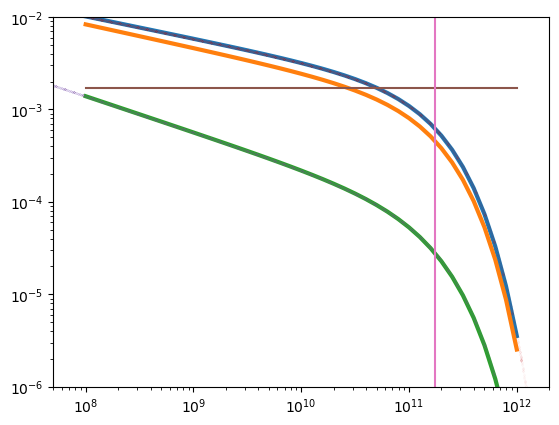

In [35]:
print(sam.mtot.shape, sam.mrat.shape, hard._sepa_init, hard._norm.shape)
mstar = sam.mass_stellar().flatten() 
print(mstar.shape)
print(mstar.min()/MSOL, mstar.max()/MSOL)
#sam_dadt_vals = hard.dadt(sam.mtot, sam.mrat, np.repeat(hard._sepa_init,sam.mtot.size))
#print("mtot [msun]:",sam.mtot/MSOL)
mstar_arr = 10**np.arange(8.0,12.1,0.1) * MSOL
print(mstar_arr.min()/MSOL, mstar_arr.max()/MSOL)

gsmf_func_z0 = sam._gsmf(mstar_arr, 0.0) / np.log(10)  # units of dex^-1 Mpc^-3
gsmf_func_z0pt4 = sam._gsmf(mstar_arr, 0.4) / np.log(10)  # units of dex^-1 Mpc^-3
gsmf_func_z0pt5 = sam._gsmf(mstar_arr, 0.5) / np.log(10)  # units of dex^-1 Mpc^-3
gsmf_func_z5 = sam._gsmf(mstar_arr, 5.0) / np.log(10)  # units of dex^-1 Mpc^-3
#print(sam._gsmf(mstar_arr, 0.0))
print(f"phi0={sam._gsmf._phi0}, phiz={sam._gsmf._phiz}")
print(f"log10(mchar0/msun)={np.log10(sam._gsmf._mchar0/MSOL):g}, log10(mcharz/msun)={np.log10(sam._gsmf._mcharz/MSOL):g}")
print(f"alpha0={sam._gsmf._alpha0}, alphaz={sam._gsmf._alphaz}")
plt.xscale('log')
plt.yscale('log')
plt.xlim(5.0e7,2.0e12)
plt.ylim(1.0e-6,0.01)
plt.plot(mstar_arr/MSOL, gsmf_func_z0, lw=3)
#plt.plot(mstar_arr/MSOL, gsmf_func_z0pt4, lw=3)
plt.plot(mstar_arr/MSOL, gsmf_func_z0pt5, lw=3)
plt.plot(mstar_arr/MSOL, gsmf_func_z5, lw=3)
plt.plot(mstar/MSOL, sam._gsmf(mstar, 0.0)/ np.log(10) ,'.',lw=0,ms=0.1,alpha=0.2)
plt.plot(mstar/MSOL, sam._gsmf(mstar, 5.0)/ np.log(10) ,'.',lw=0,ms=0.1,alpha=0.2)
phi_check_z0 = np.power(10.0, sam._gsmf._phi0 + sam._gsmf._phiz * 0.0)
m0_check = sam._gsmf._mchar0 / MSOL
plt.plot([1.0e8,1.0e12], [phi_check_z0, phi_check_z0])
plt.plot([m0_check,m0_check],[1.0e-6,1.0e-2],)

(20,) (20,) (20,) (20,)
box_vol_mpc =  1357213.6324803103


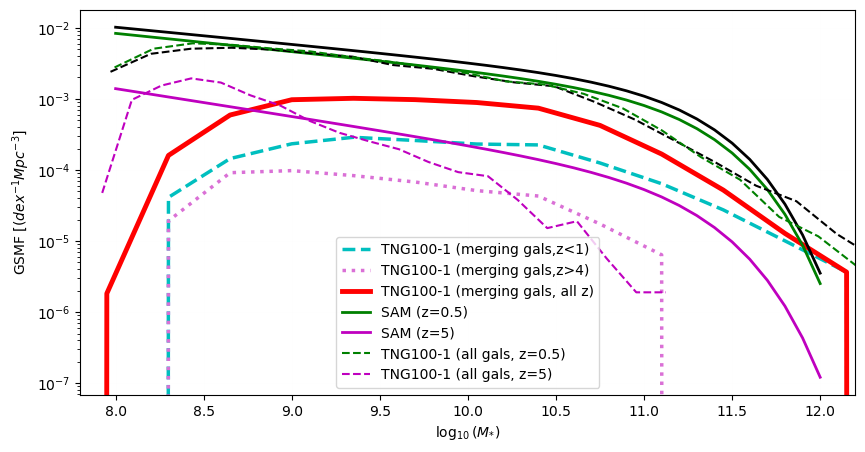

In [36]:
#compare_gsmfs([d for d in tng_dpops], colors=colors, lws=lws,
#              labels=[d.lbl for d in tng_dpops])
#compare_gsmfs([d for d in [dpop_tng100_1,dpop_tng100_2]], colors=colors, lws=lws,
#              labels=[d.lbl for d in [dpop_tng100_1,dpop_tng100_2]])
compare_gsmfs([dpop_tng100_1], colors=colors, lws=lws,
              labels=[dpop_tng100_1.lbl])
box_vol_mpc = dpop_tng100_1.evo._sample_volume / (1.0e6*PC)**3
print("box_vol_mpc = ", box_vol_mpc)
plt.xlim(7.8,12.2)
plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z0,'k',lw=2)
#plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z0pt4)
plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z0pt5,'g',lw=2,label='SAM (z=0.5)')
plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z5,'m',lw=2,label='SAM (z=5)')
plt.plot(bin_edges_snap99[:-1],gsmf_snap99,'k--')
#plt.plot(bin_edges_snap72[:-1],gsmf_snap72)
plt.plot(bin_edges_snap72[:-1],gsmf_snap67,'g--',label='TNG100-1 (all gals, z=0.5)')
plt.plot(bin_edges_snap17[:-1],gsmf_snap17,'m--',label='TNG100-1 (all gals, z=5)')
plt.legend()
plt.show()

In [ ]:
print(sam._dens_gal_gal.shape)

in function mass_stellar...
(91,) (81,) (91, 1) (1, 81)
(2, 91, 81)
(2, 91, 81)
(91, 81, 101) (91, 81) (91, 81) (101,)
mstar_pri[:,-1].shape: (91,), mstar_rat[0,:].shape: (81,)
integ (after first integration along mstar_pri): (90, 81, 101)
sam_dngalgal_dz.shape: (90, 80, 101)
sam_dngalgal_dz.shape: (80, 101)
sam_dngalgal_dz.shape: (101,)
total sam_dngalgal (from dz): 4.362465941085517
sam_dngalgal_dmstar_pri.shape: (91, 80, 100)
sam_dngalgal_dmstar_pri.shape: (91, 100)
sam_dngalgal_dmstar_pri.shape: (91,)
total sam_dngalgal (from dmstar_pri): 0.9907631688935267
sam_dngalgal_dmstar_rat.shape: (90, 81, 100)
sam_dngalgal_dmstar_rat.shape: (81, 100)
sam_dngalgal_dmstar_rat.shape: (81,)
total sam_dngalgal (from dmstar_rat): 6.890389473019528
(3284, 2) 1.3306179568569139e+41 2.5837386273508947e+45
(3284,) 1.9287658299116106e+41 2.5837386273508947e+45
(3284,) 1.3306179568569139e+41 6.087850145501861e+44
(3284,) 8.958780060763133e-05 0.9983691984943307
dngalgal_tot = 0.0024196632876421114
(307

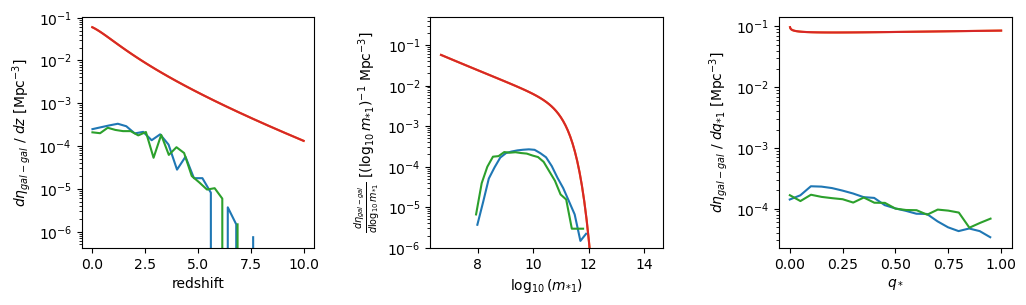

In [17]:
#ran out of time to fix this today. womp womp.
compare_gal_merger_dens([d for d in [dpop_tng100_1,dpop_tng100_2]],sam_compare=sam)

in function mass_stellar...
(91,) (81,) (91, 1) (1, 81)
(2, 91, 81)
(2, 91, 81)
sam gal merg rate shape: (91, 81, 101)
0.06068486030027388 1.368757609105896


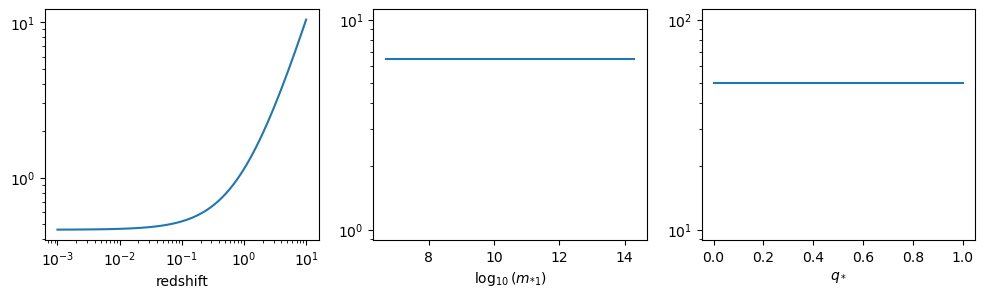

In [51]:
compare_gal_merger_rate([d for d in [dpop_tng100_1,dpop_tng100_2]],sam_compare=sam)

In [ ]:
sepa_arr = np.logspace(1.0e-6*PC, hard._sepa_init, 101)
mt, mr, sepa, norm = np.broadcast_arrays(
            sam.mtot[:, np.newaxis, np.newaxis],
            sam.mrat[np.newaxis, :, np.newaxis],
            sepa_arr[np.newaxis, np.newaxis, :],
            hard._norm[:, :, np.newaxis],
        )
print(mt.shape, mr.shape, sepa.shape)
dadt_sam = hard.dadt(mt, mr, sepa, norm)
print(dadt_sam.shape)

### Plot amplitudes at 1/yr, 1/3yr, and 1/10yr

In [ ]:
for d in all_sim_dpops + all_fsa_dpops:
    d.get_amplitudes_at_freqs()

## this is sketch. only works if freqs is same for all dpops and for sam
ayr_sam = gwb_sam[d.idx_ayr,:].flatten()
a3yr_sam = gwb_sam[d.idx_a3yr,:].flatten()
a10yr_sam = gwb_sam[d.idx_a10yr,:].flatten()


In [ ]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

kale.dist1d(np.log10(ayr_sam), density=True, hist=False, confidence=True, carpet=False, 
            lw=5, color='k', label='SAM')
for i in np.arange(len(tng_dpops)):
    kale.dist1d(np.log10(tng_dpops[i].ayr), density=True, hist=False, confidence=False, carpet=False, 
                label=tng_dpops[i].lbl, lw=lws[i], color=colors[i],alpha=0.5)
    kale.dist1d(np.log10(tng_fsa_dpops[i].ayr), density=True, hist=False, confidence=False, carpet=False, 
                label=tng_fsa_dpops[i].lbl, lw=lws[i], color=colors[i],ls='--')

plt.title("Comparison of GWB amplitudes at 1/yr")
plt.legend()
fig.savefig(f'compare_dpops_tau{tau/(1e9*YR):.1f}_A1yr.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{3yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

kale.dist1d(np.log10(a3yr_sam), density=True, hist=False, confidence=True, carpet=False, 
            lw=4, color='k', label='SAM')
for i in np.arange(len(tng_dpops)):
    kale.dist1d(np.log10(tng_dpops[i].a3yr), density=True, hist=False, confidence=False, carpet=False, 
                label=tng_dpops[i].lbl, lw=lws[i], color=colors[i],alpha=0.5)
    kale.dist1d(np.log10(tng_fsa_dpops[i].a3yr), density=True, hist=False, confidence=False, carpet=False, 
                label=tng_fsa_dpops[i].lbl, lw=lws[i], color=colors[i],ls='--')

plt.title("Comparison of GWB amplitudes at 1/3yr")
plt.legend()
fig.savefig(f'compare_dpops_tau{tau/(1e9*YR):.1f}_A0.33yr.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{10yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

kale.dist1d(np.log10(a10yr_sam), density=True, hist=False, confidence=True, carpet=False, 
            lw=4, color='k', label='SAM')
for i in np.arange(len(tng_dpops)):    
    kale.dist1d(np.log10(tng_dpops[i].a10yr), density=True, hist=False, confidence=False,  carpet=False, 
                label=tng_dpops[i].lbl, lw=lws[i], color=colors[i],alpha=0.5)
    kale.dist1d(np.log10(tng_fsa_dpops[i].a10yr), density=True, hist=False, confidence=False,  carpet=False, 
                label=tng_fsa_dpops[i].lbl, lw=lws[i], color=colors[i], ls='--')
    
#kale.dist1d(np.log10(a10yr_fsa_new_ill), density=True, confidence=False, label='a10yr_fsa_new_ill',color='m')
#kale.dist1d(np.log10(a10yr_sam), density=True, confidence=True, label='a10yr_sam')
plt.title("Comparison of GWB amplitudes at 1/10yr")
plt.legend()
fig.savefig(f'compare_dpops_tau{tau/(1e9*YR):.1f}_A0.1yr.png')
plt.show()

In [ ]:
#print(gwb_old_ill.back.shape, gwb_old_ill.fore.shape, gwb_old_ill.loudest.shape)
##plot.plot_gwb(freqs, gwb_new_ill_nst.back)
#print(freqs)
#print(gwb_old_ill.back)
for d in all_sim_dpops:
    plot.plot_gwb(d.freqs, d.gwb.back, ylim=(5.0e-17,2.0e-14))
    plt.title(d.lbl)
#plot.plot_gwb(freqs, gwb_tng50_3.back, ylim=(5.0e-17,2.0e-14))
##plot.plot_gwb(freqs, gwb_sam, ylim=(5.0e-17,2.0e-14))

plt.show()

In [ ]:
sepa = np.logspace(-4.5, 5, 100) * PC
fig, ax = plot.figax(figsize=(8,5))
for d in tng_dpops:
    plot_evo(d.evo, freqs=None, sepa=sepa, ax=ax)
    plt.title(d.lbl)
    #plot_evo(evo_tng50_3, freqs=None, sepa=sepa, ax=ax)
plt.legend()
plt.show()

In [ ]:
sepa = np.logspace(-4.5, 5, 100) * PC
fig, ax = plot.figax(figsize=(8,5))
for d in tng_fsa_dpops:
    plot_evo(d.evo, freqs=None, sepa=sepa, ax=ax)
    plt.title(d.lbl)
#plt.legend()
plt.show()

In [ ]:
# Calculate the total lifetime of each binary
ncols = 2
nrows = 3
fig, axes = plot.figax(scale='lin', xlabel='Time: actual/specified', ylabel='density',figsize=(8,5),
                       ncols=ncols, nrows=nrows, wspace=0.3,hspace=0.3)
#times = [evo_old_ill.tlook, evo_new_ill.tlook, evo_tng100_1.tlook, evo_tng300_1.tlook, hard.tlook]
times = [evo_tng100_1.tlook, evo_tng300_1.tlook, hard.tlook]

i = 0
for idx,ax in np.ndenumerate(axes):
    i = idx[0]*ncols + idx[1]
    print(f"idx: {idx}, i: {i}")
    dt = times[i][:, 0] - times[i][:, -1]
    # Create figure
    # use kalepy to plot distribution
    kale.dist1d(dt/tau, density=True, ax=ax, label=sim_names[i])
    ax.legend()
    
plt.show()

In [ ]:
for d in tng_pops:
    plot_bin_pop(d)
plt.show()

In [ ]:
#plot_mbh_scaling_relations(fsa_pop_old_ill)
#plot_mbh_scaling_relations(pop_new_ill)
#plot_mbh_scaling_relations(pop_tng100_1)
#plot_mbh_scaling_relations(pop_tng300_1)
#plot_mbh_scaling_relations(pop_old_ill,compare_pops=[pop_new_ill,pop_tng100_1,pop_tng300_1], ncols=2, nrows=2)
plot_mbh_scaling_relations(dpop_new_ill.pop, compare_pops=[d.pop for d in tng_fsa_dpops], 
                           ncols=4, nrows=2,
                           xlim=(6.5,13.2), ylim=(4.5,11.1))
plt.savefig('mmbulge_relations.png')
plt.show()

In [ ]:
print(MSOL)

In [ ]:
print(PC, YR)

In [ ]:
# ---- Old Illustris file, N=100
# Create initial population & fixed-sep population for old illustris file
#pop_old_ill = holo.population.Pop_Illustris()
#fsa_pop_old_ill = holo.population.Pop_Illustris(fixed_sepa=fixed_sepa)

# ---- New Illustris file, N=100
# Create initial population & fixed-sep population for new illustris file
#pop_new_ill = holo.population.Pop_Illustris(fname='galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5')
#fsa_pop_new_ill = holo.population.Pop_Illustris(fname='galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5',
#                                                fixed_sepa=fixed_sepa)

# ---- TNG100-1 file, N=100
#Create initial population & fixed-sep population for new illustris file
#pop_tng100_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5')
#fsa_pop_tng100_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5',
#                                                 fixed_sepa=fixed_sepa)

# ---- TNG300-1 file, N=12
# Create initial population & fixed-sep population for new illustris file
#pop_tng300_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5')
#fsa_pop_tng300_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5',
#                                                 fixed_sepa=fixed_sepa)

# ---- TNG50-1 file, N=800
#pop_tng50_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5')
#fsa_pop_tng50_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5',
#                                                fixed_sepa=fixed_sepa)

# ---- TNG50-2 file, N=100 (TNG50-2 res same as TNG100-1)
#pop_tng50_2 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5')
#fsa_pop_tng50_2 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5',
#                                                fixed_sepa=fixed_sepa)

# ---- TNG50-3 file, N=12 (TNG50-3 res same as TNG300-1)
#pop_tng50_3 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5')
#fsa_pop_tng50_3 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5',
#                                                fixed_sepa=fixed_sepa)


In [ ]:
#mmbulge = holo.relations.MMBulge_KH2013()
#mod_KH2013 = holo.population.PM_Mass_Reset(mmbulge, scatter=True)
#fsa_pop_old_ill.modify(mod_KH2013)
#fsa_pop_new_ill.modify(mod_KH2013)
#fsa_pop_tng100_1.modify(mod_KH2013)
#fsa_pop_tng300_1.modify(mod_KH2013)
#fsa_pop_tng50_1.modify(mod_KH2013)
#fsa_pop_tng50_2.modify(mod_KH2013)
#fsa_pop_tng50_3.modify(mod_KH2013)


In [ ]:
## create a fixed-total-time hardening mechanism
#fsa_fixed_old_ill = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_old_ill, tau)
## Create an evolution instance using population and hardening mechanism, and evolve it
#fsa_evo_old_ill = holo.evolution.Evolution(fsa_pop_old_ill, fsa_fixed_old_ill)
#fsa_evo_old_ill.evolve()
#print("vol:",fsa_evo_old_ill._sample_volume)

## create a fixed-total-time hardening mechanism
#fsa_fixed_new_ill = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_new_ill, tau)
## Create an evolution instance using population and hardening mechanism, and evolve it
#fsa_evo_new_ill = holo.evolution.Evolution(fsa_pop_new_ill, fsa_fixed_new_ill)
#fsa_evo_new_ill.evolve()
#print("vol:",fsa_evo_new_ill._sample_volume)

## create a fixed-total-time hardening mechanism
#fsa_fixed_tng100_1 = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_tng100_1, tau)
## Create an evolution instance using population and hardening mechanism
#fsa_evo_tng100_1 = holo.evolution.Evolution(fsa_pop_tng100_1, fsa_fixed_tng100_1)
## evolve binary population
#fsa_evo_tng100_1.evolve()
#print("vol:",fsa_evo_tng100_1._sample_volume)

## create a fixed-total-time hardening mechanism
#fsa_fixed_tng300_1 = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_tng300_1, tau)
## Create an evolution instance using population and hardening mechanism
#fsa_evo_tng300_1 = holo.evolution.Evolution(fsa_pop_tng300_1, fsa_fixed_tng300_1)
## evolve binary population
#fsa_evo_tng300_1.evolve()
#print("vol:",fsa_evo_tng300_1._sample_volume)

## create a fixed-total-time hardening mechanism
#fsa_fixed_tng50_1 = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_tng50_1, tau)
## Create an evolution instance using population and hardening mechanism
#fsa_evo_tng50_1 = holo.evolution.Evolution(fsa_pop_tng50_1, fsa_fixed_tng50_1)
## evolve binary population
#fsa_evo_tng50_1.evolve()
#print("vol:",fsa_evo_tng50_1._sample_volume)

## create a fixed-total-time hardening mechanism
#fsa_fixed_tng50_2 = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_tng50_2, tau)
## Create an evolution instance using population and hardening mechanism
#fsa_evo_tng50_2 = holo.evolution.Evolution(fsa_pop_tng50_2, fsa_fixed_tng50_2)
## evolve binary population
#fsa_evo_tng50_2.evolve()
#print("vol:",fsa_evo_tng50_2._sample_volume)

## create a fixed-total-time hardening mechanism
#fsa_fixed_tng50_3 = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_tng50_3, tau)
## Create an evolution instance using population and hardening mechanism
#fsa_evo_tng50_3 = holo.evolution.Evolution(fsa_pop_tng50_3, fsa_fixed_tng50_3)
## evolve binary population
#fsa_evo_tng50_3.evolve()
#print("vol:",fsa_evo_tng50_3._sample_volume)


In [ ]:
# ---- Evolve binary populations

# ---- Old Illustris file

# create a fixed-total-time hardening mechanism
#fixed_old_ill = holo.hardening.Fixed_Time_2PL.from_pop(pop_old_ill, tau)
# Create an evolution instance using population and hardening mechanism, and evolve it
#evo_old_ill = holo.evolution.Evolution(pop_old_ill, fixed_old_ill)
#evo_old_ill.evolve()
#print("vol:",evo_old_ill._sample_volume)


## ---- New illustris file (no subtrees - like old file)

## Create initial population for new illustris file (no subtrees - like old file)
##pop_new_ill_nst = holo.population.Pop_Illustris(fname='nosubtrees-galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5')

# Evolve new illustris (no subtrees) binary population
# create a fixed-total-time hardening mechanism
#fixed_new_ill_nst = holo.hardening.Fixed_Time_2PL.from_pop(pop_new_ill_nst, tau)
# Create an evolution instance using population and hardening mechanism
#evo_new_ill_nst = holo.evolution.Evolution(pop_new_ill_nst, fixed_new_ill_nst)
# evolve binary population
#evo_new_ill_nst.evolve()

# ---- New Illustris file

# create a fixed-total-time hardening mechanism
#fixed_new_ill = holo.hardening.Fixed_Time_2PL.from_pop(pop_new_ill, tau)
# Create an evolution instance using population and hardening mechanism, and evolve it
#evo_new_ill = holo.evolution.Evolution(pop_new_ill, fixed_new_ill)
#evo_new_ill.evolve()
#print("vol:",evo_new_ill._sample_volume)


# ---- TNG100-1 file

# create a fixed-total-time hardening mechanism
#fixed_tng100_1 = holo.hardening.Fixed_Time_2PL.from_pop(pop_tng100_1, tau)
# Create an evolution instance using population and hardening mechanism
#evo_tng100_1 = holo.evolution.Evolution(pop_tng100_1, fixed_tng100_1)
# evolve binary population
#evo_tng100_1.evolve()
#print("vol:",evo_tng100_1._sample_volume)


# ---- TNG300-1 file

# create a fixed-total-time hardening mechanism
#fixed_tng300_1 = holo.hardening.Fixed_Time_2PL.from_pop(pop_tng300_1, tau)
# Create an evolution instance using population and hardening mechanism
#evo_tng300_1 = holo.evolution.Evolution(pop_tng300_1, fixed_tng300_1)
# evolve binary population
#evo_tng300_1.evolve()
#print("vol:",evo_tng300_1._sample_volume)

# ---- TNG50-1 file

# create a fixed-total-time hardening mechanism
#fixed_tng50_1 = holo.hardening.Fixed_Time_2PL.from_pop(pop_tng50_1, tau)
# Create an evolution instance using population and hardening mechanism
#evo_tng50_1 = holo.evolution.Evolution(pop_tng50_1, fixed_tng50_1)
# evolve binary population
#evo_tng50_1.evolve()
#print("vol:",evo_tng50_1._sample_volume)

# ---- TNG50-2 file

# create a fixed-total-time hardening mechanism
#fixed_tng50_2 = holo.hardening.Fixed_Time_2PL.from_pop(pop_tng50_2, tau)
# Create an evolution instance using population and hardening mechanism
#evo_tng50_2 = holo.evolution.Evolution(pop_tng50_2, fixed_tng50_2)
# evolve binary population
#evo_tng50_2.evolve()
#print("vol:",evo_tng50_2._sample_volume)

# ---- TNG50-1 file

# create a fixed-total-time hardening mechanism
#fixed_tng50_3 = holo.hardening.Fixed_Time_2PL.from_pop(pop_tng50_3, tau)
# Create an evolution instance using population and hardening mechanism
#evo_tng50_3 = holo.evolution.Evolution(pop_tng50_3, fixed_tng50_3)
# evolve binary population
#evo_tng50_3.evolve()
#print("vol:",evo_tng50_3._sample_volume)



In [ ]:
# ---- Create GWB for each discrete population

# old illustris file
#gwb_old_ill = holo.gravwaves.GW_Discrete(evo_old_ill, freqs, nreals=500)
#gwb_old_ill.emit()

# new illustris file (no subtrees - like old file)
##gwb_new_ill_nst = holo.gravwaves.GW_Discrete(evo_new_ill_nst, freqs, nreals=1000)
##gwb_new_ill_nst.emit()

## new illustris file
#gwb_new_ill = holo.gravwaves.GW_Discrete(evo_new_ill, freqs, nreals=500)
#gwb_new_ill.emit()

## TNG100-1 file
#gwb_tng100_1 = holo.gravwaves.GW_Discrete(evo_tng100_1, freqs, nreals=500)
#gwb_tng100_1.emit()

## TNG300-1 file
#gwb_tng300_1 = holo.gravwaves.GW_Discrete(evo_tng300_1, freqs, nreals=500)
#gwb_tng300_1.emit()

## TNG50-1 file
#gwb_tng50_1 = holo.gravwaves.GW_Discrete(evo_tng50_1, freqs, nreals=500)
#gwb_tng50_1.emit()

## TNG50-2 file
#gwb_tng50_2 = holo.gravwaves.GW_Discrete(evo_tng50_2, freqs, nreals=500)
#gwb_tng50_2.emit()

## TNG50-3 file
#gwb_tng50_3 = holo.gravwaves.GW_Discrete(evo_tng50_3, freqs, nreals=500)
#gwb_tng50_3.emit()


In [ ]:
#fsa_gwb_old_ill = holo.gravwaves.GW_Discrete(fsa_evo_old_ill, freqs, nreals=500)
#fsa_gwb_old_ill.emit()

#fsa_gwb_new_ill = holo.gravwaves.GW_Discrete(fsa_evo_new_ill, freqs, nreals=500)
#fsa_gwb_new_ill.emit()

#fsa_gwb_tng100_1 = holo.gravwaves.GW_Discrete(fsa_evo_tng100_1, freqs, nreals=500)
#fsa_gwb_tng100_1.emit()

#fsa_gwb_tng300_1 = holo.gravwaves.GW_Discrete(fsa_evo_tng300_1, freqs, nreals=500)
#fsa_gwb_tng300_1.emit()

#fsa_gwb_tng50_1 = holo.gravwaves.GW_Discrete(fsa_evo_tng50_1, freqs, nreals=500)
#fsa_gwb_tng50_1.emit()

#fsa_gwb_tng50_2 = holo.gravwaves.GW_Discrete(fsa_evo_tng50_2, freqs, nreals=500)
#fsa_gwb_tng50_2.emit()

#fsa_gwb_tng50_3 = holo.gravwaves.GW_Discrete(fsa_evo_tng50_3, freqs, nreals=500)
#fsa_gwb_tng50_3.emit()

In [ ]:

# ---- amplitudes at ~ 1 / yr
#ayr_old_ill = gwb_old_ill.back[idx_ayr,:].flatten()
#ayr_new_ill = gwb_new_ill.back[idx_ayr,:].flatten()
#ayr_tng100_1 = gwb_tng100_1.back[idx_ayr,:].flatten()
#ayr_tng300_1 = gwb_tng300_1.back[idx_ayr,:].flatten()
#ayr_tng50_1 = gwb_tng50_1.back[idx_ayr,:].flatten()
#ayr_tng50_2 = gwb_tng50_2.back[idx_ayr,:].flatten()
#ayr_tng50_3 = gwb_tng50_3.back[idx_ayr,:].flatten()
#ayr_mod_tng300_1 = mod_gwb_tng300_1.back[idx_ayr,:].flatten()
#ayr_sam = gwb_sam[idx_ayr,:].flatten()

#ayr_fsa_old_ill = fsa_gwb_old_ill.back[idx_ayr,:].flatten()
#ayr_fsa_new_ill = fsa_gwb_new_ill.back[idx_ayr,:].flatten()
#ayr_fsa_tng100_1 = fsa_gwb_tng100_1.back[idx_ayr,:].flatten()
#ayr_fsa_tng300_1 = fsa_gwb_tng300_1.back[idx_ayr,:].flatten()
#ayr_fsa_tng50_1 = fsa_gwb_tng50_1.back[idx_ayr,:].flatten()
#ayr_fsa_tng50_2 = fsa_gwb_tng50_2.back[idx_ayr,:].flatten()
#ayr_fsa_tng50_3 = fsa_gwb_tng50_3.back[idx_ayr,:].flatten()
#ayr_rescale_fsa_tng300_1 = rescale_fsa_gwb_tng300_1.back[idx_ayr,:].flatten()

# ---- amplitudes at ~ 1 / 3yr
#a3yr_old_ill = gwb_old_ill.back[idx_a3yr,:].flatten()
#a3yr_new_ill = gwb_new_ill.back[idx_a3yr,:].flatten()
#a3yr_tng100_1 = gwb_tng100_1.back[idx_a3yr,:].flatten()
#a3yr_tng300_1 = gwb_tng300_1.back[idx_a3yr,:].flatten()
#a3yr_tng50_1 = gwb_tng50_1.back[idx_a3yr,:].flatten()
#a3yr_tng50_2 = gwb_tng50_2.back[idx_a3yr,:].flatten()
#a3yr_tng50_3 = gwb_tng50_3.back[idx_a3yr,:].flatten()
#a3yr_mod_tng300_1 = mod_gwb_tng300_1.back[idx_a3yr,:].flatten()
#a3yr_sam = gwb_sam[idx_a3yr,:].flatten()

#a3yr_fsa_old_ill = fsa_gwb_old_ill.back[idx_a3yr,:].flatten()
#a3yr_fsa_new_ill = fsa_gwb_new_ill.back[idx_a3yr,:].flatten()
#a3yr_fsa_tng100_1 = fsa_gwb_tng100_1.back[idx_a3yr,:].flatten()
#a3yr_fsa_tng300_1 = fsa_gwb_tng300_1.back[idx_a3yr,:].flatten()
#a3yr_fsa_tng50_1 = fsa_gwb_tng50_1.back[idx_a3yr,:].flatten()
#a3yr_fsa_tng50_2 = fsa_gwb_tng50_2.back[idx_a3yr,:].flatten()
#a3yr_fsa_tng50_3 = fsa_gwb_tng50_3.back[idx_a3yr,:].flatten()
#a3yr_rescale_fsa_tng300_1 = rescale_fsa_gwb_tng300_1.back[idx_a3yr,:].flatten()

# ---- amplitudes at ~ 1 / 10yr
#a10yr_old_ill = gwb_old_ill.back[idx_a10yr,:].flatten()
#a10yr_new_ill = gwb_new_ill.back[idx_a10yr,:].flatten()
#a10yr_tng100_1 = gwb_tng100_1.back[idx_a10yr,:].flatten()
#a10yr_tng300_1 = gwb_tng300_1.back[idx_a10yr,:].flatten()
#a10yr_tng50_1 = gwb_tng50_1.back[idx_a10yr,:].flatten()
#a10yr_tng50_2 = gwb_tng50_2.back[idx_a10yr,:].flatten()
#a10yr_tng50_3 = gwb_tng50_3.back[idx_a10yr,:].flatten()
#a10yr_mod_tng300_1 = mod_gwb_tng300_1.back[idx_a10yr,:].flatten()
#a10yr_sam = gwb_sam[idx_a10yr,:].flatten()

#a10yr_fsa_old_ill = fsa_gwb_old_ill.back[idx_a10yr,:].flatten()
#a10yr_fsa_new_ill = fsa_gwb_new_ill.back[idx_a10yr,:].flatten()
#a10yr_fsa_tng100_1 = fsa_gwb_tng100_1.back[idx_a10yr,:].flatten()
#a10yr_fsa_tng300_1 = fsa_gwb_tng300_1.back[idx_a10yr,:].flatten()
#a10yr_fsa_tng50_1 = fsa_gwb_tng50_1.back[idx_a10yr,:].flatten()
#a10yr_fsa_tng50_2 = fsa_gwb_tng50_2.back[idx_a10yr,:].flatten()
#a10yr_fsa_tng50_3 = fsa_gwb_tng50_3.back[idx_a10yr,:].flatten()
#a10yr_rescale_fsa_tng300_1 = rescale_fsa_gwb_tng300_1.back[idx_a10yr,:].flatten()

#print(ayr_old_ill.shape)